Xiao Yang, xy2696

Shruti Murali, sm5941

Hope Min, hm3119

Riddhi Parakh, rp3326

Austin Zeng, yz5119


# Citi Bike Demand Analysis

This notebook analyses Citi Bike trips for a sample of New York City stations to understand usage, and prepare inputs for a station-level demand forecasting model. The analysis loads (and cleans) data, features time-based variables like trip date, hour and day of the week as well as exploratory graphics that explore rider behavior by bike type, user demographic and time.

The main goals are:

* Explain how membership type, station,weather, holidays and time of day or week relate to ridership.

* Construct aggregated daily demand by station dataset that can be used as the target of downstream machine-learning models.




In [ ]:
# Import core libraries for data manipulation, numerical computation, and plotting
import pandas as pd
import numpy as np
from datetime import timedelta
import os, re

import duckdb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import plotly.graph_objects as go
import matplotlib.dates as mdates
from plotly.subplots import make_subplots


from google.colab import drive
from xgboost import XGBRegressor
import holidays

from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


###Data Concatenation

Using paraquet file to filter the the top 6 stations in each borough, and storing the output as a csv file. Also saving this file locally, to avoid filtering step.

In [ ]:
con = duckdb.connect()

# Borough boundaries
borough_bounds = {
    "Manhattan": (40.70, 40.88, -74.02, -73.93),
    "Brooklyn":  (40.57, 40.73, -74.04, -73.85),
    "Queens":    (40.54, 40.80, -73.96, -73.70),
    "Bronx":     (40.79, 40.91, -73.93, -73.77),
    "Staten Island": (40.48, 40.65, -74.25, -74.05),
}

PARQUET_PATH = "/content/drive/MyDrive/Data Analytics/Data Analytics Group-5/citibike.parquet"


### STEP 1 — Get top 6 stations (station_name + count)
def get_top6_stations(borough, bounds):
    lat_min, lat_max, lon_min, lon_max = bounds
    df = con.execute(f"""
        SELECT
            start_station_name,
            COUNT(*) AS total_starts
        FROM (
            SELECT
                start_station_name,
                start_lat,
                start_lng
            FROM '{PARQUET_PATH}'
        )
        WHERE start_lat BETWEEN {lat_min} AND {lat_max}
          AND start_lng BETWEEN {lon_min} AND {lon_max}
        GROUP BY start_station_name
        ORDER BY total_starts DESC
        LIMIT 6;
    """).df()
    return df


### STEP 2 — Pull ALL trip data for those stations
def get_full_data_for_stations(station_list):
    station_str = "', '".join(station_list)
    df = con.execute(f"""
        SELECT *
        FROM '{PARQUET_PATH}'
        WHERE start_station_name IN ('{station_str}');
    """).df()
    return df


### RUN FOR ALL BOROUGHS
full_results = []

for borough, bounds in borough_bounds.items():

    # Step 1: top 6 stations
    top6 = get_top6_stations(borough, bounds)

    print(f"\nTop 6 in {borough}:\n", top6)

    station_list = top6["start_station_name"].tolist()

    # Step 2: get all columns for these stations
    full_df = get_full_data_for_stations(station_list)
    full_df["borough"] = borough  # label for clarity

    full_results.append(full_df)


### FINAL FULL DATAFRAME (ALL COLUMNS)
final_df = pd.concat(full_results, ignore_index=True)

final_df


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 6 in Manhattan:
         start_station_name  total_starts
0          W 21 St & 6 Ave        499095
1    West St & Chambers St        428101
2       Broadway & W 58 St        415214
3  University Pl & E 14 St        396823
4          W 31 St & 7 Ave        384588
5         11 Ave & W 41 St        380365


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 6 in Brooklyn:
          start_station_name  total_starts
0     West St & Chambers St        428103
1  Cleveland Pl & Spring St        335834
2      West St & Liberty St        315040
3    Norfolk St & Broome St        293485
4     Clinton St & Grand St        288438
5     Canal St & Rutgers St        284602


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 6 in Queens:
      start_station_name  total_starts
0       1 Ave & E 68 St        330650
1       E 85 St & 3 Ave        239541
2    E 72 St & York Ave        230706
3       5 Ave & E 87 St        221211
4       2 Ave & E 72 St        216239
5  N 6 St & Bedford Ave        215205


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
final_df

In [ ]:
# Store all rides for top 6 stations
final_df.to_csv('/content/drive/MyDrive/Data Analytics/Data Analytics Group-5/citibike_top6_stations.csv', index=False)

#### Data Cleaning and Preprocessing

This step refines the Citi Bike trip sample into a reliable analysis dataset by standardizing timestamps, filtering out implausible trip durations, and harmonizing key categorical fields. Additional date and time features are engineered to capture day, hour, and month patterns that are important for understanding station‑level demand. The resulting table retains only valid same‑day trips and drops intermediate technical columns to keep the structure clean and focused

In [ ]:
# Load the preprocessed Citi Bike sample for the chosen stations
df=pd.read_csv("/content/drive/MyDrive/Data Analytics/Data Analytics Group-5/Group_5_Citibike_Daily_Demand_Forecasting/citibike_top6_stations.csv")# add drive link

In [ ]:
#Summary of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6195918 entries, 0 to 6195917
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
 13  borough             object 
dtypes: float64(4), object(10)
memory usage: 661.8+ MB


started_at and ended_at are objects, but will be needed as time while performing modelling

In [ ]:
# This cell converts the 'started_at' and 'ended_at' columns to datetime objects.
# The 'errors='coerce'' argument will turn any unparseable date/time strings into NaT (Not a Time).
# After conversion, it removes rows where either 'started_at' or 'ended_at' resulted in NaT,
# ensuring only valid datetime entries are kept for duration calculations.
df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
df['ended_at'] = pd.to_datetime(df['ended_at'], errors='coerce')

#Removing errored datetime
df = df.dropna(subset=['started_at', 'ended_at'])
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,borough
0,2A8C48BF9FF396CC,classic_bike,2022-06-01 09:12:45.678,2022-06-01 09:51:17.662,Broadway & W 58 St,6948.1,West Thames St,5114.06,40.766953,-73.981693,40.708347,-74.017134,casual,Manhattan
1,09C27335513BAD0E,electric_bike,2022-06-28 20:18:51.481,2022-06-28 20:51:29.007,Broadway & W 58 St,6948.1,W 160 St & St. Nicholas Ave,8138.07,40.766953,-73.981693,40.834468,-73.939865,casual,Manhattan
2,7FB010D36C9C4B46,classic_bike,2022-06-15 09:12:49.514,2022-06-15 09:24:48.672,Broadway & W 58 St,6948.1,W 33 St & 10 Ave,6492.04,40.766953,-73.981693,40.753773,-73.999376,member,Manhattan
3,EC95D2C753DC808F,electric_bike,2022-06-10 13:43:30.267,2022-06-10 14:17:11.046,University Pl & E 14 St,5905.14,West Thames St,5114.06,40.734814,-73.992085,40.708347,-74.017134,member,Manhattan
4,9BE04BE50589B7B6,electric_bike,2022-06-25 12:56:06.606,2022-06-25 13:50:13.827,University Pl & E 14 St,5905.14,Devoe St & Lorimer St,5259.06,40.734617,-73.992218,40.713352,-73.949103,member,Manhattan


In [ ]:
#Removing invalid durations
#Train duration considered from 0 to 24 hr
df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df = df[(df['duration_min'] > 0) & (df['duration_min'] < 1440)]
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,borough,duration_min
0,2A8C48BF9FF396CC,classic_bike,2022-06-01 09:12:45.678,2022-06-01 09:51:17.662,Broadway & W 58 St,6948.1,West Thames St,5114.06,40.766953,-73.981693,40.708347,-74.017134,casual,Manhattan,38.533067
1,09C27335513BAD0E,electric_bike,2022-06-28 20:18:51.481,2022-06-28 20:51:29.007,Broadway & W 58 St,6948.1,W 160 St & St. Nicholas Ave,8138.07,40.766953,-73.981693,40.834468,-73.939865,casual,Manhattan,32.625433
2,7FB010D36C9C4B46,classic_bike,2022-06-15 09:12:49.514,2022-06-15 09:24:48.672,Broadway & W 58 St,6948.1,W 33 St & 10 Ave,6492.04,40.766953,-73.981693,40.753773,-73.999376,member,Manhattan,11.985967
3,EC95D2C753DC808F,electric_bike,2022-06-10 13:43:30.267,2022-06-10 14:17:11.046,University Pl & E 14 St,5905.14,West Thames St,5114.06,40.734814,-73.992085,40.708347,-74.017134,member,Manhattan,33.679650
4,9BE04BE50589B7B6,electric_bike,2022-06-25 12:56:06.606,2022-06-25 13:50:13.827,University Pl & E 14 St,5905.14,Devoe St & Lorimer St,5259.06,40.734617,-73.992218,40.713352,-73.949103,member,Manhattan,54.120350


In [ ]:
df['rideable_type'].unique()

array(['classic_bike', 'electric_bike'], dtype=object)

In [ ]:
# This cell aims to uniform the categorical variables in the DataFrame to ensure consistency and prevent issues due to varying cases or leading/trailing spaces.
# Specifically, it converts the 'rideable_type' and 'member_casual' columns to lowercase and removes any leading or trailing whitespace.
# It also removes leading/trailing whitespace from 'start_station_name' and 'end_station_name'
df['rideable_type'] = df['rideable_type'].str.strip().str.lower()
df['member_casual'] = df['member_casual'].str.strip().str.lower()
df['start_station_name'] = df['start_station_name'].str.strip()
df['end_station_name'] = df['end_station_name'].str.strip()

In [ ]:
#Removing duplicates if any
df = df.drop_duplicates()
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,borough,duration_min
0,2A8C48BF9FF396CC,classic_bike,2022-06-01 09:12:45.678,2022-06-01 09:51:17.662,Broadway & W 58 St,6948.1,West Thames St,5114.06,40.766953,-73.981693,40.708347,-74.017134,casual,Manhattan,38.533067
1,09C27335513BAD0E,electric_bike,2022-06-28 20:18:51.481,2022-06-28 20:51:29.007,Broadway & W 58 St,6948.1,W 160 St & St. Nicholas Ave,8138.07,40.766953,-73.981693,40.834468,-73.939865,casual,Manhattan,32.625433
2,7FB010D36C9C4B46,classic_bike,2022-06-15 09:12:49.514,2022-06-15 09:24:48.672,Broadway & W 58 St,6948.1,W 33 St & 10 Ave,6492.04,40.766953,-73.981693,40.753773,-73.999376,member,Manhattan,11.985967
3,EC95D2C753DC808F,electric_bike,2022-06-10 13:43:30.267,2022-06-10 14:17:11.046,University Pl & E 14 St,5905.14,West Thames St,5114.06,40.734814,-73.992085,40.708347,-74.017134,member,Manhattan,33.679650
4,9BE04BE50589B7B6,electric_bike,2022-06-25 12:56:06.606,2022-06-25 13:50:13.827,University Pl & E 14 St,5905.14,Devoe St & Lorimer St,5259.06,40.734617,-73.992218,40.713352,-73.949103,member,Manhattan,54.120350


In [ ]:
## include data where start_date == end_date
df['start_date'] = df['started_at'].dt.date
df['start_time'] = df['started_at'].dt.time

df['end_date'] = df['ended_at'].dt.date
df['end_time'] = df['ended_at'].dt.time
# Keeping the trips with the start and end dates are same
df['Trip_Date'] = df[df['start_date'] == df['end_date']]['start_date']


df['start_hour'] = df['started_at'].dt.hour
df['start_day_of_week'] = df['started_at'].dt.day_name()
df['start_month'] = df['started_at'].dt.month

# Remove other columns

df.drop(columns=['end_date','start_date','started_at','ended_at'],inplace=True)
df.head()

,ride_id,rideable_type,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,borough,duration_min,start_time,end_time,Trip_Date,start_hour,start_day_of_week,start_month
0,2A8C48BF9FF396CC,classic_bike,Broadway & W 58 St,6948.1,West Thames St,5114.06,40.766953,-73.981693,40.708347,-74.017134,casual,Manhattan,38.533067,09:12:45.678000,09:51:17.662000,2022-06-01,9,Wednesday,6
1,09C27335513BAD0E,electric_bike,Broadway & W 58 St,6948.1,W 160 St & St. Nicholas Ave,8138.07,40.766953,-73.981693,40.834468,-73.939865,casual,Manhattan,32.625433,20:18:51.481000,20:51:29.007000,2022-06-28,20,Tuesday,6
2,7FB010D36C9C4B46,classic_bike,Broadway & W 58 St,6948.1,W 33 St & 10 Ave,6492.04,40.766953,-73.981693,40.753773,-73.999376,member,Manhattan,11.985967,09:12:49.514000,09:24:48.672000,2022-06-15,9,Wednesday,6
3,EC95D2C753DC808F,electric_bike,University Pl & E 14 St,5905.14,West Thames St,5114.06,40.734814,-73.992085,40.708347,-74.017134,member,Manhattan,33.679650,13:43:30.267000,14:17:11.046000,2022-06-10,13,Friday,6
4,9BE04BE50589B7B6,electric_bike,University Pl & E 14 St,5905.14,Devoe St & Lorimer St,5259.06,40.734617,-73.992218,40.713352,-73.949103,member,Manhattan,54.120350,12:56:06.606000,13:50:13.827000,2022-06-25,12,Saturday,6


### EDA

This section summarizes Citi Bike usage patterns by trip duration, rider type, bike type, borough, and station, using grouped statistics and bar charts to highlight the most active locations and segments. Spatial and calendar heatmaps are used to visualize how demand varies across New York City and over days, weeks, and hours, including separate calendars for members versus casual riders. Together, these visualizations reveal temporal peaks, spatial hotspots, and distinct behavior differences between user and bike categories, providing intuition for subsequent modeling and recommendations.

In [ ]:
# --- Ride duration statistics ---
print("Duration stats by rideable_type:")
print(df.groupby('rideable_type')['duration_min'].describe())

print("\nDuration stats by member type:")
print(df.groupby('member_casual')['duration_min'].describe())


Duration stats by rideable_type:
                   count       mean        std       min       25%       50%  \
rideable_type                                                                  
classic_bike   2735858.0  14.852297  31.406288  1.000850  5.398204  9.821308   
electric_bike  3456945.0  13.704553  19.944197  1.000083  5.694217  9.669500   

                     75%          max  
rideable_type                          
classic_bike   18.088346  1439.923900  
electric_bike  16.231850  1439.900833  

Duration stats by member type:
                   count       mean        std       min       25%        50%  \
member_casual                                                                   
casual         1217105.0  22.780629  40.240593  1.002367  8.605900  15.123517   
member         4975698.0  12.115535  20.016260  1.000083  5.130633   8.824283   

                     75%          max  
member_casual                          
casual         26.205483  1439.923900  
member   

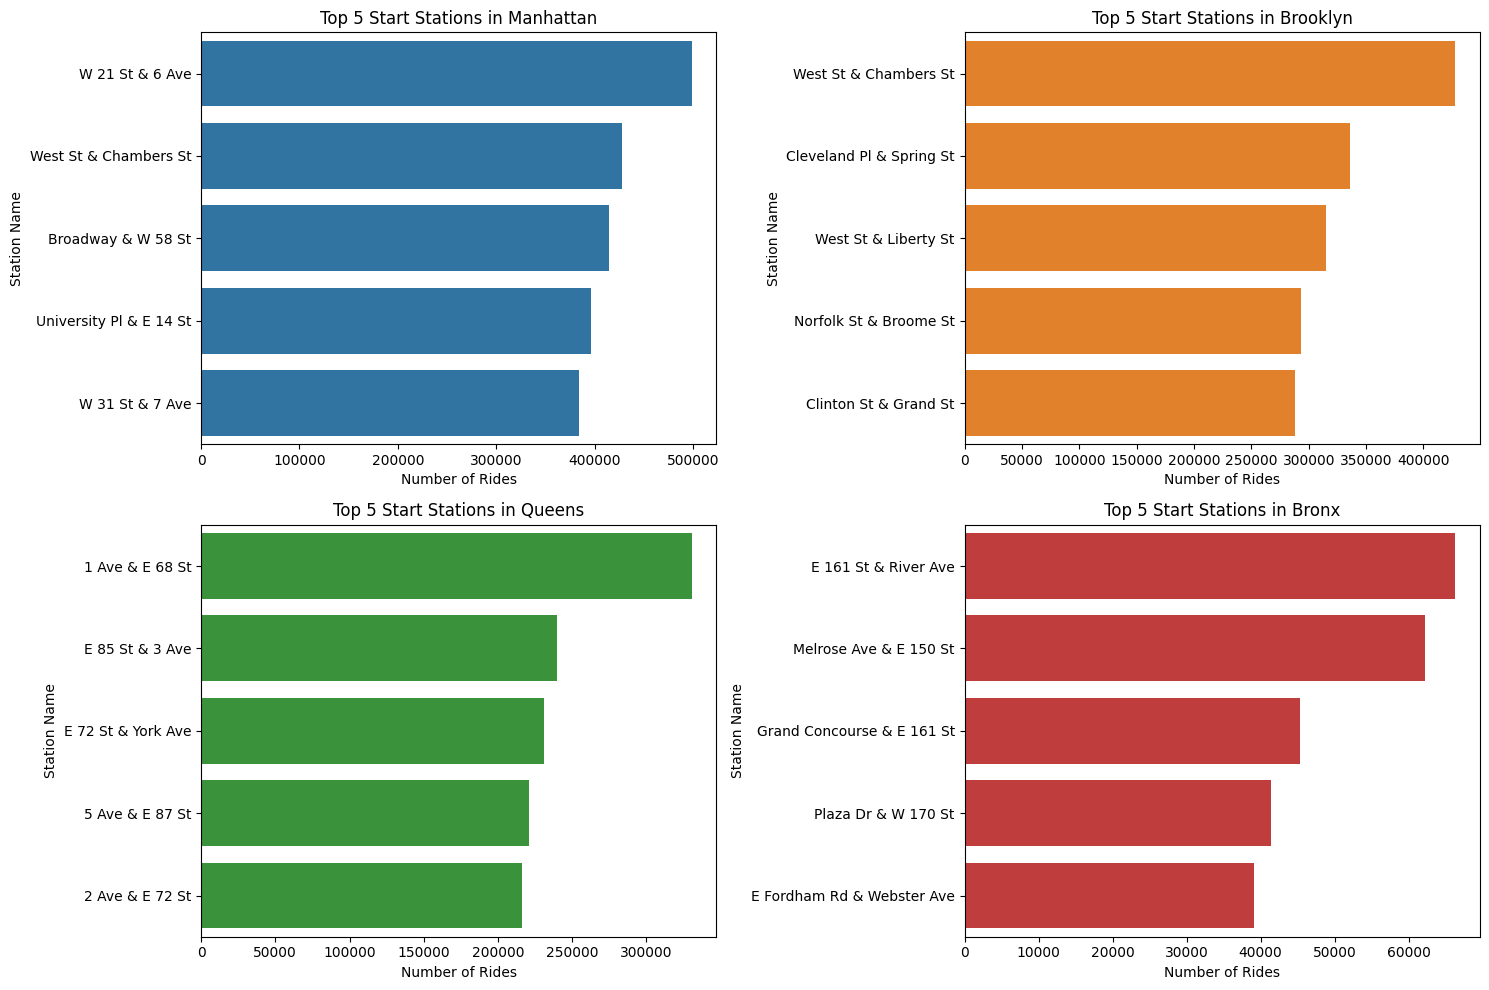

In [ ]:
# Define a color palette for boroughs
borough_colors = {
    'Manhattan': '#1f77b4',   # blue
    'Brooklyn': '#ff7f0e',    # orange
    'Queens': '#2ca02c',      # green
    'Bronx': '#d62728',       # red
    'Staten Island': '#9467bd' # purple
}

# Set up figure
plt.figure(figsize=(15, 10))

# Loop through boroughs
for i, borough in enumerate(df['borough'].dropna().unique(), 1):
    plt.subplot(2, 2, i)  # adjust grid depending on number of boroughs

    # Get top 5 stations as a DataFrame
    top_stations = (
        df[df['borough'] == borough]['start_station_name']
        .value_counts()
        .head(5)
        .reset_index()
    )
    top_stations.columns = ['station', 'rides']

    # Plot with borough-specific color
    sns.barplot(
        x='rides',
        y='station',
        data=top_stations,
        color=borough_colors.get(borough, "#333333")  # default gray if not in dict
    )
    plt.title(f'Top 5 Start Stations in {borough}')
    plt.xlabel('Number of Rides')
    plt.ylabel('Station Name')
    # plt.xlim(0, top_stations['rides'].max() * 1.1)  # Hope: unniform x-axis limits

plt.tight_layout()
plt.show()



In Manhattan borough, W 21 St & 6 ave with almost 5,00,000, West St and Chambers St in brooklyn borough with approx 4,50,000.

Queens borough most busiest station is 1 ave & E 68 st with over 3,00,000 and around 60000 rides from E 616 St & River Ave in Bronx

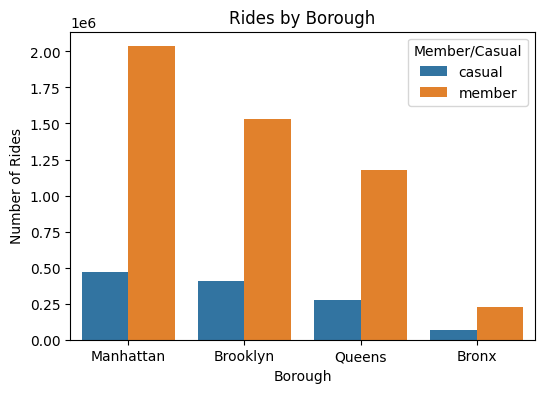

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='borough', data=df, hue='member_casual')
plt.title('Rides by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Rides')
plt.legend(title='Member/Casual')
plt.show()


Number of rider type across each borough, Manhattan having the highest number of member riders.

In [ ]:
# --- Map visualization of start stations (optional) ---
# Create a map centered in NYC

m = folium.Map(location=[40.75, -73.98], zoom_start=12)

# Plot top 50 start stations
top6_stations = df.groupby(['start_station_name','start_lat','start_lng']).size().reset_index(name='ride_count')
top6_stations = top6_stations.sort_values('ride_count', ascending=False).head(50)

for _, row in top6_stations.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=row['ride_count']**0.1,  # scale the circle
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['start_station_name']}: {row['ride_count']} rides"
    ).add_to(m)
display(m)

Geographic location of the stations in each borough

In [ ]:
# First, create a summary dataframe for top routes
route_counts = df.groupby(['start_station_name', 'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng']).size().reset_index(name='count')
top_routes = route_counts.nlargest(50, 'count') # Get top 50 routes

# Create the map figure
fig = px.scatter_mapbox(top_routes,
                        lat="start_lat", lon="start_lng",
                        hover_name="start_station_name",
                        hover_data=["end_station_name", "count"],
                        size="count",
                        color="count",
                        zoom=10, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Manhattan has the highest number of riders.

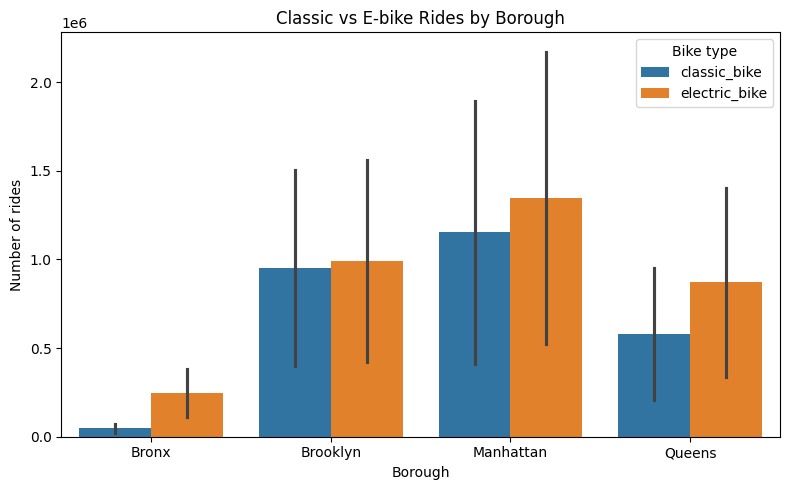

In [ ]:
# Aggregate counts by borough, bike type, and rider type
tmp = df[df["borough"].notna() & df["rideable_type"].notna()]
borough_bike = (
    tmp.groupby(["borough", "rideable_type", "member_casual"])
       .size()
       .reset_index(name="rides")
)

# Pivot so we can stack classic vs electric
pivot = borough_bike.pivot_table(
    index=["borough", "member_casual"],
    columns="rideable_type",
    values="rides",
    aggfunc="sum",
    fill_value=0
).reset_index()

# Long form for plotting
plot_df = pivot.melt(
    id_vars=["borough", "member_casual"],
    value_vars=["classic_bike", "electric_bike"],
    var_name="rideable_type",
    value_name="rides"
)

# One figure, stacked bars, faceted by rider type
plt.figure(figsize=(8, 5))
sns.barplot(
    data=plot_df,
    x="borough",
    y="rides",
    hue="rideable_type",
    estimator=sum
)

plt.title("Classic vs E-bike Rides by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of rides")
plt.legend(title="Bike type")
plt.tight_layout()
plt.show()


There are more users in Manhattan who prefer electric bike over classic bike, bronx has the lowest number of e-bike users.

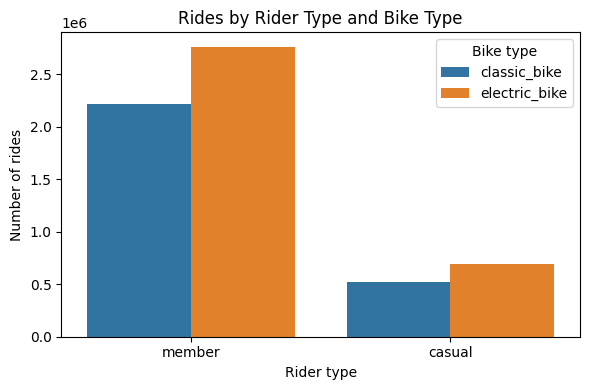

In [ ]:
# df should have: rideable_type, member_casual
tmp = df.dropna(subset=["rideable_type", "member_casual"])

# Aggregate counts
rider_bike = (
    tmp.groupby(["member_casual", "rideable_type"])
       .size()
       .reset_index(name="rides")
)

# Sort rider type for nicer order
rider_order = ["member", "casual"] if set(rider_bike["member_casual"]) >= {"member","casual"} else None

plt.figure(figsize=(6,4))
sns.barplot(
    data=rider_bike,
    x="member_casual",
    y="rides",
    hue="rideable_type",
    order=rider_order
)
plt.title("Rides by Rider Type and Bike Type")
plt.xlabel("Rider type")
plt.ylabel("Number of rides")
plt.legend(title="Bike type")
plt.tight_layout()
plt.show()


Overall, member riders prefer electric bikes.

In [ ]:
# Create pivot table for calendar heatmap
daily_rides = df.groupby('Trip_Date').size().reset_index(name='ride_count')

# Add back date components to the aggregated data
daily_rides['Trip_Date'] = pd.to_datetime(daily_rides['Trip_Date'])
daily_rides['year'] = daily_rides['Trip_Date'].dt.year
daily_rides['month'] = daily_rides['Trip_Date'].dt.month
daily_rides['day'] = daily_rides['Trip_Date'].dt.day
daily_rides['day_of_week'] = daily_rides['Trip_Date'].dt.dayofweek
daily_rides['week_of_year'] = daily_rides['Trip_Date'].dt.isocalendar().week
daily_rides['day_name'] = daily_rides['Trip_Date'].dt.day_name()
daily_rides['month_name'] = daily_rides['Trip_Date'].dt.month_name()


pivot_table = daily_rides.pivot_table(
    index='week_of_year',
    columns='day_of_week',
    values='ride_count',
    aggfunc='sum',
    fill_value=0
)

# Create the calendar heatmap
fig = px.imshow(
    pivot_table.values,
    x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    y=pivot_table.index,
    color_continuous_scale='Viridis',
    aspect="auto"
)

# Customize the layout
fig.update_layout(
    title='Ride Activity Calendar Heatmap',
    xaxis_title='Day of Week',
    yaxis_title='Week of Year',
    coloraxis_colorbar=dict(title='Number of Rides'),
    height=800
)

# Improve hover template
fig.update_traces(
    hovertemplate='<b>Week %{y}</b><br>%{x}<br>Rides: %{z}<extra></extra>'
)

fig.show()

Around week 30, which is summer time, number of rider increases. The rise is particular high on wednesday.

During winter months the number of rides decreases.

In [ ]:
def create_comparison_calendar_heatmap(df, year=None):
    """
    Create side-by-side calendar heatmaps for member vs casual
    """
    df['Trip_Date']=pd.to_datetime(df['Trip_Date'])
    if year:
        df = df[df['Trip_Date'].dt.year == year]

    # Create subplots

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['Member Rides', 'Casual Rides'],
        shared_yaxes=True
    )

    for i, user_type in enumerate(['member', 'casual'], 1):
        user_data = df[df['member_casual'] == user_type]

        # Prepare data
        user_data['date'] = user_data['Trip_Date'].dt.date
        daily_rides = user_data.groupby('Trip_Date').size().reset_index(name='ride_count')
        daily_rides['date'] = pd.to_datetime(daily_rides['Trip_Date'])
        daily_rides['day_of_week'] = daily_rides['Trip_Date'].dt.dayofweek
        daily_rides['week_of_year'] = daily_rides['Trip_Date'].dt.isocalendar().week

        # Create pivot table
        pivot_table = daily_rides.pivot_table(
            index='week_of_year',
            columns='day_of_week',
            values='ride_count',
            aggfunc='sum',
            fill_value=0
        )

        # Add heatmap to subplot
        heatmap = go.Heatmap(
            z=pivot_table.values,
            x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            y=[f"Week {int(w)}" for w in pivot_table.index],
            colorscale='Viridis',
            showscale=(i == 2),  # Only show colorbar for second plot
            hovertemplate='Week %{y}<br>%{x}<br>Rides: %{z}<extra></extra>'
        )

        fig.add_trace(heatmap, row=1, col=i)

    fig.update_layout(
        title_text=f"Ride Activity Comparison - Member vs Casual {f'({year})' if year else ''}",
        height=600,
        width=1200
    )

    return fig

# Create comparison heatmap
comparison_fig = create_comparison_calendar_heatmap(df, year=2022)
comparison_fig.show()

The graph clearly differentiates between the utility-driven usage of member riders,
concentrated on weekdays for commuting, and the leisure-oriented usage of casual riders,
who predominantly use the service on weekends. This understanding is vital for operations,
bike distribution, and marketing strategies aimed at both user segments.

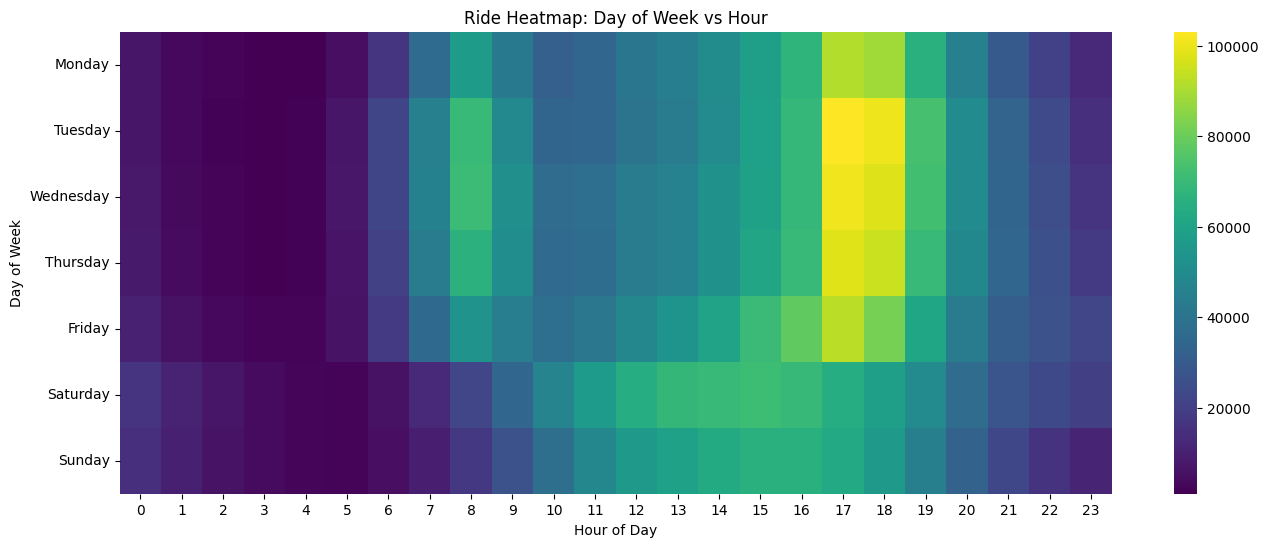

In [ ]:
pivot = df.pivot_table(
    index='start_day_of_week',
    columns='start_hour',
    values='ride_id',
    aggfunc='count'
).fillna(0)

# Sort days
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = pivot.reindex(order)

plt.figure(figsize=(16,6))
sns.heatmap(pivot, cmap='viridis')
plt.title("Ride Heatmap: Day of Week vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

This graph shows the number of rides taking during each hour.Weekday has the highest number of rides in evening around 5pm



#### Featuring Engineering

This section prepares a station-day level dataset that combines Citi Bike demand with temporal, holiday, and local weather signals for each location. The resulting daily_demand_features table is a clean, modeling-ready panel designed to support robust daily demand forecasting at the station level

In [ ]:
# This cell prepares the data for daily demand prediction by aggregating rides, filling missing dates,
# and enriching the dataset with external features like weekend/holiday flags and weather data.

# Aggregate data for daily demand prediction:
# Group the DataFrame by 'start_station_name' and 'Trip_Date' and count the number of rides per day per station.
# This results in a 'daily_rides' column representing the demand.
daily = (df.groupby(['start_station_name','Trip_Date'])
          .size().reset_index(name='daily_rides'))
# Filling Missing dates:
# This function ensures that there's a record for every day within the observed period for each station.
# It creates a date range from the minimum to maximum 'Trip_Date' for each station,
# reindexes the daily rides data to include all dates, and fills missing 'daily_rides' values with 0.
def fill_dates(g):
    dr = pd.date_range(g['Trip_Date'].min(), g['Trip_Date'].max(), freq='D')
    out = (g.set_index('Trip_Date')
             .reindex(dr, fill_value=0)['daily_rides']
             .reset_index())
    out.columns = ['Trip_Date','daily_rides']
    out['start_station_name'] = g['start_station_name'].iloc[0]
    return out

# Apply the 'fill_dates' function to each station group to create a complete daily time series.
daily_all = pd.concat([fill_dates(g) for _, g in daily.groupby('start_station_name')], ignore_index=True)

# Adding holiday factor to the daily data:
# Initialize a US holiday calendar for New York state.
ny_holidays = holidays.US(state='NY')
# Create 'is_weekend' flag (1 if Saturday/Sunday, 0 otherwise).
daily_all['is_weekend'] = (daily_all['Trip_Date'].dt.dayofweek >= 5).astype(int)
# Create 'is_holiday' flag (1 if a New York state holiday, 0 otherwise).
daily_all['is_holiday'] = daily_all['Trip_Date'].isin(ny_holidays).astype(int)

# Prepare metadata for fetching weather data:
# Group by 'start_station_name' to get mean latitude and longitude for each station.
meta = (df.groupby('start_station_name')
          .agg(start_lat=('start_lat','mean'), start_lng=('start_lng','mean'))
          .reset_index())
# Get the start and end dates for each station's data coverage.
span = (daily_all.groupby('start_station_name')
          .agg(start=('Trip_Date','min'), end=('Trip_Date','max'))
          .reset_index())
# Merge station coordinates with their data date ranges.
info = meta.merge(span, on='start_station_name')

# Define the Open-Meteo API endpoint and timezone for weather data.
API = "https://archive-api.open-meteo.com/v1/archive"
TZ = "America/New_York"
weather_all = []

# Fetch historical weather data for each station:
# Iterate through each station's info (name, lat, lon, start/end dates).
# Construct API request parameters to get daily max temperature and precipitation.
# Attempt to fetch data; if successful, store it in a DataFrame. If an error occurs (e.g., API timeout),
# create a DataFrame with default 0.0 values for temperature and precipitation for the date range.
for _, r in info.iterrows():
    s, lat, lon = r['start_station_name'], float(r['start_lat']), float(r['start_lng'])
    start, end = r['start'].strftime('%Y-%m-%d'), r['end'].strftime('%Y-%m-%d')
    params = {
        "latitude": lat, "longitude": lon,
        "start_date": start, "end_date": end,
        "daily": ["temperature_2m_max","precipitation_sum"],
        "timezone": TZ
    }
    try:
        # Make API request and parse JSON response.
        j = requests.get(API, params=params, timeout=20).json()
        w = pd.DataFrame({
            "Trip_Date": pd.to_datetime(j['daily']['time']),
            "temperature": j['daily']['temperature_2m_max'],
            "precipitation": j['daily']['precipitation_sum']
        })
    except Exception:
        # Handle API request errors by creating a placeholder weather DataFrame.
        w = pd.DataFrame({"Trip_Date": pd.date_range(start, end, freq='D'),"temperature": 0.0, "precipitation": 0.0})

    # Add the station name to the weather data and collect it.
    w['start_station_name'] = s
    weather_all.append(w)

# Concatenate all collected weather data into a single DataFrame.
weather_all = pd.concat(weather_all, ignore_index=True)

# Final merge: Combine the daily ride data (with weekend/holiday flags) with the fetched weather data.
# This creates the final 'daily_demand_features' DataFrame, ready for modeling.
daily_demand_features = daily_all.merge(weather_all, on=['start_station_name','Trip_Date'], how='left')

In [ ]:
daily_demand_features.head()

,Trip_Date,daily_rides,start_station_name,is_weekend,is_holiday,temperature,precipitation
0,2022-06-01,389,1 Ave & E 68 St,0,0,0.0,0.0
1,2022-06-02,412,1 Ave & E 68 St,0,0,0.0,0.0
2,2022-06-03,414,1 Ave & E 68 St,0,0,0.0,0.0
3,2022-06-04,271,1 Ave & E 68 St,1,0,0.0,0.0
4,2022-06-05,233,1 Ave & E 68 St,1,0,0.0,0.0


In [ ]:
daily_demand_features.shape

(27305, 7)

### Modelling

This section develops 4 predictive models to explain and forecast daily Citi Bike demand at the station level using the engineered temporal and weather features. The goal is to quantify how usage responds to factors such as day-of-week, rider type, and weather conditions, and to generate accurate daily demand predictions.

In [ ]:
# Set up valuation metrics

def mae(y, p): return np.mean(np.abs(y - p))
def rmse(y, p): return np.sqrt(np.mean((y - p) ** 2))
def mape(y, p):
    y = np.array(y); p = np.array(p); mask = y != 0
    return np.mean(np.abs((y[mask] - p[mask]) / y[mask])) if mask.any() else np.nan
def smape(y, p):
    y = np.array(y); p = np.array(p); denom = (np.abs(y) + np.abs(p)); mask = denom != 0
    return np.mean(2.0 * np.abs(y - p) / denom[mask]) if mask.any() else np.nan

In [ ]:
# Set up function  for feature engineering
def make_features(df):
    df = df.sort_values('Trip_Date').copy()
    df['dow'] = df['Trip_Date'].dt.dayofweek
    df['week'] = df['Trip_Date'].dt.isocalendar().week.astype(int)
    df['month'] = df['Trip_Date'].dt.month
    for lag in [1,7,14]: df[f'lag_{lag}'] = df['daily_rides'].shift(lag)
    for w in [7,14,28]: df[f'roll_mean_{w}'] = df['daily_rides'].shift(1).rolling(w).mean()
    for col in ['is_weekend','is_holiday','temperature','precipitation']:
        if col not in df.columns: df[col] = 0
    return df



Model 1: Prophet

In [ ]:
dd = daily_demand_features.copy()
dd['Trip_Date'] = pd.to_datetime(dd['Trip_Date'])
dd = dd.sort_values(['start_station_name','Trip_Date'])


In [ ]:
try:
    from prophet import Prophet
except:
    from fbprophet import Prophet

eval_rows = []

# Run on all stations and evaluate the performance

for station, g in dd.groupby('start_station_name'):
    g = g[['Trip_Date','daily_rides']].sort_values('Trip_Date')
    if len(g) < 60:
        continue
    train = g.iloc[:-30].rename(columns={'Trip_Date':'ds','daily_rides':'y'})
    valid = g.iloc[-30:].rename(columns={'Trip_Date':'ds','daily_rides':'y'})

    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(train)
    yhat = m.predict(valid[['ds']])['yhat'].values

    eval_rows.append({
        'start_station_name': station,
        'MAE': mae(valid['y'], yhat),
        'RMSE': rmse(valid['y'], yhat),
        'MAPE': mape(valid['y'], yhat),
        'sMAPE': smape(valid['y'], yhat)
    })

eval_df_prophet = pd.DataFrame(eval_rows).set_index('start_station_name')
print(eval_df_prophet)

                                   MAE        RMSE      MAPE     sMAPE
start_station_name                                                    
1 Ave & E 68 St              35.583960   50.542445  0.107452  0.100375
11 Ave & W 41 St             50.193392   82.367969  0.179574  0.125471
2 Ave & E 72 St              23.042503   31.898824  0.115158  0.104767
5 Ave & E 87 St              60.605729   87.844569  0.216418  0.201227
Broadway & W 58 St           48.721331   68.703407  0.120295  0.109062
Canal St & Rutgers St        54.114655   69.108191  0.163850  0.160276
Cleveland Pl & Spring St     69.680570  128.402596  0.145868  0.140141
Clinton St & Grand St        90.985560  108.005803  0.224044  0.259424
E 161 St & River Ave         24.077419   35.193321  0.252678  0.244308
E 72 St & York Ave           35.985037   41.718515  0.149174  0.162334
E 85 St & 3 Ave              35.925973   59.923383  0.570924  0.151712
E Fordham Rd & Webster Ave    4.315172    5.591213  0.146011  0.134354
Grand 

The table shows that forecast accuracy differs noticeably by station and by error metric. Stations such as **“2 Ave & E 72 St”** and **“E Fordham Rd & Webster Ave”** have relatively low MAE and RMSE, indicating the model captures their daily demand patterns reasonably well, whereas locations like **“West St & Chambers St”** and **“N 6 St & Bedford Ave”** exhibit much larger absolute errors, suggesting demand there is harder to predict, likely due to higher volume or greater volatility.  

Percentage-based errors offer a more comparable view across stations: many sites have sMAPE in roughly the 0.10–0.20 range, which corresponds to moderate relative error, but others such as **“E 85 St & 3 Ave”**, **“Grand Concourse & E 161 St”**, and **“N 6 St & Bedford Ave”** show elevated MAPE or sMAPE, implying that forecasts at these locations are less reliable and may be affected by noisier or sparser data.  

Taken together, the pattern is consistent with higher‑volume stations tending to show larger absolute errors (MAE, RMSE) while maintaining percentage errors that are often comparable to, or only slightly worse than, lower‑volume sites, which is expected when deviations scale with underlying demand levels.

Model 2: XGBoost

In [ ]:
# Model 2: XGBoost
eval_rows = []

# Run on all stations and evaluate the performance

for station, g in dd.groupby('start_station_name'):
    g = g[['Trip_Date','daily_rides','is_weekend','is_holiday','temperature','precipitation']].sort_values('Trip_Date')
    if len(g) < 60:
        continue

    # split train/test sets
    train = g.iloc[:-30].copy()
    valid = g.iloc[-30:].copy()

    f_train = make_features(train)
    f_all = make_features(pd.concat([train, valid], ignore_index=True))
    f_valid = f_all.iloc[len(train):]

    feat_cols = [c for c in f_train.columns if c not in ['Trip_Date','daily_rides']]
    f_train_model = f_train.dropna(subset=feat_cols + ['daily_rides'])
    X_tr, y_tr = f_train_model[feat_cols], f_train_model['daily_rides']
    X_va = f_valid[feat_cols].fillna(f_train_model['daily_rides'].mean())

    model = XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, random_state=42)
    model.fit(X_tr, y_tr)
    yhat = model.predict(X_va)

    eval_rows.append({
        'start_station_name': station,
        'MAE': mae(valid['daily_rides'], yhat),
        'RMSE': rmse(valid['daily_rides'], yhat),
        'MAPE': mape(valid['daily_rides'], yhat),
        'sMAPE': smape(valid['daily_rides'], yhat)
    })

eval_df_xgb = pd.DataFrame(eval_rows).set_index('start_station_name')
print(eval_df_xgb)

                                   MAE        RMSE      MAPE     sMAPE
start_station_name                                                    
1 Ave & E 68 St              38.290278   57.294569  0.111433  0.105657
11 Ave & W 41 St             54.367407   80.298872  0.169113  0.140012
2 Ave & E 72 St              27.521343   33.627379  0.123135  0.123780
5 Ave & E 87 St              63.555385   90.347009  0.233440  0.216643
Broadway & W 58 St           65.832694   87.744496  0.158178  0.149954
Canal St & Rutgers St        53.132427   69.942880  0.167262  0.160170
Cleveland Pl & Spring St     90.081907  136.727380  0.185017  0.193160
Clinton St & Grand St        79.422811   98.118830  0.210309  0.231689
E 161 St & River Ave         23.467825   34.697781  0.239307  0.244954
E 72 St & York Ave           22.646567   31.369005  0.103866  0.102183
E 85 St & 3 Ave              42.014342   66.411891  0.631227  0.171858
E Fordham Rd & Webster Ave    4.914977    6.260570  0.165207  0.150565
Grand 

Model performance differs noticeably across stations, with XGBoost delivering strong accuracy for many locations but still struggling at a few high‑volume or volatile sites. Stations such as “E 72 St & York Ave”, “W 21 St & 6 Ave”, and “1 Ave & E 68 St” achieve relatively low MAE, RMSE, and sMAPE, while “West St & Chambers St” and a handful of others retain large absolute errors despite some improvement. Overall, sMAPE values are typically in the 0.10–0.20 range, indicating reasonably tight relative errors for most stations, but outliers like “E 85 St & 3 Ave” highlight where demand patterns or data quality may require additional scrutiny or station‑specific refinements.


Model 3: Lightgbm

In [ ]:
# Model 3: Lightgbm


eval_rows = []

# Run on all stations and evaluate the performance
for station, g in dd.groupby('start_station_name'):
    g = g[['Trip_Date','daily_rides','is_weekend','is_holiday','temperature','precipitation']].sort_values('Trip_Date')
    if len(g) < 60:
        continue
    train = g.iloc[:-30].copy()
    valid = g.iloc[-30:].copy()

    f_train = make_features(train)
    f_all = make_features(pd.concat([train, valid], ignore_index=True))
    f_valid = f_all.iloc[len(train):]

    feat_cols = [c for c in f_train.columns if c not in ['Trip_Date','daily_rides']]
    f_train_model = f_train.dropna(subset=feat_cols + ['daily_rides'])
    X_tr, y_tr = f_train_model[feat_cols], f_train_model['daily_rides']
    X_va = f_valid[feat_cols].fillna(f_train_model['daily_rides'].mean())

    model = LGBMRegressor(n_estimators=400, learning_rate=0.05,
                          subsample=0.8, colsample_bytree=0.8, random_state=42)
    model.fit(X_tr, y_tr)
    yhat = model.predict(X_va)

    eval_rows.append({
        'start_station_name': station,
        'MAE': mae(valid['daily_rides'], yhat),
        'RMSE': rmse(valid['daily_rides'], yhat),
        'MAPE': mape(valid['daily_rides'], yhat),
        'sMAPE': smape(valid['daily_rides'], yhat)
    })

eval_df_lgb = pd.DataFrame(eval_rows).set_index('start_station_name')
print(eval_df_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 10
[LightGBM] [Info] Start training from score 272.729204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 10
[LightGBM] [Info] Start training from score 315.555752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1575
[LightGBM] [Info] Number of data points in the train s

LightGBM delivers broadly strong performance on daily station demand, with many locations achieving sMAPE in roughly the 0.10–0.20 range and moderate MAE/RMSE, indicating reasonably tight forecasts for most stations. Stations such as “E 72 St & York Ave”, “W 21 St & 6 Ave”, and “1 Ave & E 68 St” show particularly good accuracy, while “Clinton St & Grand St”, “West St & Chambers St”, and “E 85 St & 3 Ave” remain harder to predict, combining large absolute errors with elevated percentage errors at some sites. Overall, LightGBM is competitive with the tree‑boosting baselines, but the spread in errors across stations suggests that demand patterns are heterogeneous and a single global model may still leave room for station‑specific tuning or additional features in the most challenging locations.


Model 4: ARIMA (SARIMAX)

In [ ]:
# Model 4: ARIMA (SARIMAX)

# pip install statsmodels --quiet

eval_rows = []

for station, g in dd.groupby('start_station_name'):
    g = g[['Trip_Date','daily_rides']].sort_values('Trip_Date')
    if len(g) < 60:
        continue
    train = g.iloc[:-30].copy()
    valid = g.iloc[-30:].copy()

    model = SARIMAX(train['daily_rides'].astype(float),
                    order=(2,1,2), seasonal_order=(1,1,1,7),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    yhat = res.get_forecast(steps=30).predicted_mean.values

    eval_rows.append({
        'start_station_name': station,
        'MAE': mae(valid['daily_rides'], yhat),
        'RMSE': rmse(valid['daily_rides'], yhat),
        'MAPE': mape(valid['daily_rides'], yhat),
        'sMAPE': smape(valid['daily_rides'], yhat)
    })

eval_df_arima = pd.DataFrame(eval_rows).set_index('start_station_name')
print(eval_df_arima)

                                   MAE        RMSE      MAPE     sMAPE
start_station_name                                                    
1 Ave & E 68 St              32.440873   48.264015  0.103685  0.094194
11 Ave & W 41 St             52.921127   78.575497  0.179473  0.132084
2 Ave & E 72 St              21.973468   28.987035  0.108905  0.100429
5 Ave & E 87 St              60.351395   87.285805  0.216150  0.200274
Broadway & W 58 St           51.759826   70.366767  0.124135  0.115696
Canal St & Rutgers St        44.560922   62.784660  0.151820  0.132416
Cleveland Pl & Spring St     71.178452  132.467982  0.144266  0.143357
Clinton St & Grand St        66.076254   83.683042  0.162308  0.179778
E 161 St & River Ave         24.841042   37.063949  0.248460  0.252618
E 72 St & York Ave           21.102152   27.395511  0.092931  0.092408
E 85 St & 3 Ave              42.813646   63.016907  0.576721  0.177895
E Fordham Rd & Webster Ave    5.137637    6.491320  0.176882  0.158003
Grand 

SARIMAX delivers competitive accuracy for many stations, with several locations achieving lower or comparable error metrics relative to the tree‑based models, especially on sMAPE and RMSE. Stations such as “E 72 St & York Ave”, “W 21 St & 6 Ave”, “2 Ave & E 72 St”, and “1 Ave & E 68 St” show strong performance, with sMAPE often below 0.10 and relatively modest MAE and RMSE, indicating that the seasonal time‑series structure is well captured at these sites. In contrast, high‑volume or more volatile stations like “West St & Chambers St”, “Norfolk St & Broome St”, and “E 85 St & 3 Ave” still exhibit large absolute or percentage errors, suggesting that purely time‑series dynamics are not sufficient there and may need to be complemented with richer exogenous features or station‑specific modeling.

Comparison of models

In [ ]:
# Comparision of models using weighted sMAPE

weights = (daily_demand_features.groupby('start_station_name')['daily_rides']
           .sum().rename('weight'))

def weighted_smape(eval_df):
    df = eval_df.reset_index().merge(weights, on='start_station_name', how='left')
    df['weight'] = df['weight'].fillna(1.0)
    return (df['sMAPE'] * df['weight']).sum() / df['weight'].sum()

print(f"Prophet Weighted sMAPE:  {weighted_smape(eval_df_prophet):.4f}")
print(f"XGBoost Weighted sMAPE:  {weighted_smape(eval_df_xgb):.4f}")
print(f"LightGBM Weighted sMAPE: {weighted_smape(eval_df_lgb):.4f}")
print(f"ARIMA Weighted sMAPE:    {weighted_smape(eval_df_arima):.4f}")

Prophet Weighted sMAPE:  0.1659
XGBoost Weighted sMAPE:  0.1621
LightGBM Weighted sMAPE: 0.1717
ARIMA Weighted sMAPE:    0.1412


ARIMA achieves the lowest weighted sMAPE (0.1412), outperforming Prophet (0.1659), XGBoost (0.1621), and LightGBM (0.1717) on the station‑weighted error metric. Given this superior aggregate accuracy, the ARIMA specification is used as the primary model for daily Citi Bike demand prediction in the analysis

To visualize the results, we plotted two separate charts for each station. First, we plotted the full historical data alongside the forecast to illustrate the long-term trend. Then we plotted the last 90 days of historical demand combined with the 30-day forecast to show the short-term dynamics. Finally, all the prediction results were exported and saved as CSV files.

In [ ]:
# -------------------------------------------------------------------------
# 1. Helper Function: Create Future Exogenous Variables
# -------------------------------------------------------------------------
def create_future_exog(last_date, periods, history_df):
    """
    Creates a dataframe for the next 30 days with exogenous variables.
    - Date/Weekend: Calculated accurately.
    - Weather: Uses the average of the last 30 days from history as an estimate.
    """
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)
    future_df = pd.DataFrame({'Trip_Date': future_dates})

    # 1. Time features
    future_df['Trip_Date'] = pd.to_datetime(future_df['Trip_Date'])
    future_df['is_weekend'] = future_df['Trip_Date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
    future_df['is_holiday'] = 0 # Simplified: set to 0. Update if you have a holiday calendar.

    # 2. Weather features (Use recent 30-day average as a proxy for future weather)
    recent_avg_temp = history_df['temperature'].iloc[-30:].mean()
    recent_avg_precip = history_df['precipitation'].iloc[-30:].mean()

    future_df['temperature'] = recent_avg_temp
    future_df['precipitation'] = recent_avg_precip

    return future_df[['is_weekend', 'is_holiday', 'temperature', 'precipitation']], future_dates

# -------------------------------------------------------------------------
# 2. Main Process: Training, Forecasting, and Plotting
# -------------------------------------------------------------------------
# Ensure 'daily_demand_features' is loaded and date is datetime
# daily_demand_features = pd.read_csv('daily_demand_features.csv') # Uncomment if needed
daily_demand_features['Trip_Date'] = pd.to_datetime(daily_demand_features['Trip_Date'])

stations = daily_demand_features['start_station_name'].unique()
exog_cols = ['is_weekend', 'is_holiday', 'temperature', 'precipitation']
all_forecasts = []

print(f"Starting forecast for {len(stations)} stations (30 days ahead)...\n")

for i, station in enumerate(stations):
    # --- 2.1 Data Preparation ---
    df_station = daily_demand_features[daily_demand_features['start_station_name'] == station].copy()
    df_station = df_station.sort_values('Trip_Date')

    # Check for sufficient data points
    if len(df_station) < 50:
        print(f"Skipping {station}: Insufficient data ({len(df_station)} rows)")
        continue

    y_train = df_station['daily_rides']
    X_train = df_station[exog_cols]

    # --- 2.2 Forecast Future 30 Days ---
    try:
        last_date = df_station['Trip_Date'].max()
        future_exog, future_dates = create_future_exog(last_date, 30, df_station)

        # ARIMA Training
        # Using (1,1,1) x (1,0,0,7) as default parameters. Adjust 'seasonal_order' if needed.
        model = SARIMAX(endog=y_train, exog=X_train,
                        order=(1, 1, 1), seasonal_order=(1, 0, 0, 7),
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Get forecast and confidence intervals
        forecast_obj = results.get_forecast(steps=30, exog=future_exog)
        forecast_values = np.maximum(forecast_obj.predicted_mean, 0) # Clip negative values
        conf_int = forecast_obj.conf_int(alpha=0.05)
        conf_int[conf_int < 0] = 0

        # Store results
        temp_res = pd.DataFrame({
            'Trip_Date': future_dates,
            'start_station_name': station,
            'predicted_demand': forecast_values.values
        })
        all_forecasts.append(temp_res)

        # --- 2.3 Plotting (1x2 Layout) ---
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # === Left Plot: Full History + Forecast ===
        ax1 = axes[0]
        ax1.plot(df_station['Trip_Date'], df_station['daily_rides'], label='Historical (All)', color='#1f77b4', linewidth=1)
        ax1.plot(future_dates, forecast_values, label='Forecast (30 Days)', color='#d62728', linestyle='--', linewidth=2)
        ax1.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='#d62728', alpha=0.15)

        ax1.set_title(f"Station: {station} - Full History & Forecast", fontsize=12, fontweight='bold')
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Daily Rides")
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)

        # === Right Plot: Recent 90 Days + Forecast ===
        ax2 = axes[1]
        recent_90 = df_station.iloc[-90:] # Get last 90 days

        ax2.plot(recent_90['Trip_Date'], recent_90['daily_rides'], label='Historical (Last 90 Days)', color='#2ca02c', marker='.', markersize=4, linewidth=1.5)
        ax2.plot(future_dates, forecast_values, label='Forecast (30 Days)', color='#d62728', linestyle='--', linewidth=2, marker='.', markersize=4)
        ax2.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='#d62728', alpha=0.15)

        ax2.set_title(f"Station: {station} - Recent 90 Days & Forecast", fontsize=12, fontweight='bold')
        ax2.set_xlabel("Date")
        ax2.set_ylabel("Daily Rides")
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        # Format dates to avoid overlap
        fig.autofmt_xdate()

        plt.show() # Display inline in notebook

        print(f"[{i+1}/{len(stations)}] Completed: {station}")

    except Exception as e:
        print(f"[{i+1}/{len(stations)}] Failed {station}: {e}")

# -------------------------------------------------------------------------
# 3. Export CSV
# -------------------------------------------------------------------------
if all_forecasts:
    final_forecast_df = pd.concat(all_forecasts, ignore_index=True)
    output_csv_name = 'arima_future_30_days_forecast.csv'
    final_forecast_df.to_csv(output_csv_name, index=False)
    print(f"\n========================================")
    print(f"All tasks completed!")
    print(f"Forecast results saved to: {output_csv_name}")
    print(f"========================================")
else:
    print("No forecasts were generated. Please check your data.")

Output hidden; open in https://colab.research.google.com to view.

## Conclusion

This notebook cleaned and explored Citi Bike trip data for the top stations in New York City, producing a station‑level daily demand dataset enriched with temporal, weather, and holiday features. The EDA highlighted strong weekly and seasonal patterns, clear differences between member and casual riders, and substantial spatial concentration of demand in a small set of Manhattan stations.

These findings motivated the choice of features and model design for subsequent forecasting work: lagged daily demand and rolling windows to capture temporal dependence, plus exogenous variables to account for weather and holidays. The resulting dataset and visual insights provide a solid foundation for training and evaluating machine‑learning models that predict next‑day station‑level demand and support data‑driven operational decisions for Citi Bike.
